In [3]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import pandas as pd
import swifter

pd.set_option("display.max_columns", None)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.rcParams["lines.linewidth"] = 2
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 16
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.bbox"] = "tight"
from tqdm.auto import tqdm

import glob
from pathlib import Path

import h3.api.numpy_int as h3
from stc_unicef_cpi.data import process_geotiff as pg


# Reduce full dataset to NGA

In [10]:
df = pd.read_csv(
    "/Users/johnf/Downloads/raw_low_res_dssg/dhs/childpoverty_microdata_gps_21jun22.csv"
)


/var/folders/fc/4tmtzm3n327_sp7y205dwl4h0000gn/T/ipykernel_63577/263308421.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/johnf/Downloads/raw_low_res_dssg/dhs/childpoverty_microdata_gps_21jun22.csv')


In [11]:
nga_df = df[df["countrycode"].str.strip() == "NGA"]


In [14]:
nga_df.dropna(subset=["LATNUM", "LONGNUM"], inplace=True)


/var/folders/fc/4tmtzm3n327_sp7y205dwl4h0000gn/T/ipykernel_63577/1755469988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nga_df.dropna(subset=['LATNUM','LONGNUM'], inplace=True)


In [39]:
nga_df["hex_code"] = nga_df[["LATNUM", "LONGNUM"]].apply(
    lambda row: h3.geo_to_h3(row["LATNUM"], row["LONGNUM"], 7), axis=1
)


In [40]:
nga_df = nga_df.reset_index().drop(columns=["index"]).copy()


In [41]:
nga_df.to_csv(
    "/Users/johnf/Downloads/raw_low_res_dssg/dhs/clean_nga_dhs.csv", index=False
)


# Load preprocessed NGA data

In [24]:
nga_df = pd.read_csv("/Users/johnf/Downloads/raw_low_res_dssg/dhs/clean_nga_dhs.csv")


In [25]:
nga_df.hex_code.value_counts().describe()


count    1358.000000
mean       70.827688
std        34.331554
min         6.000000
25%        45.000000
50%        64.000000
75%        92.000000
max       472.000000
Name: hex_code, dtype: float64

In [26]:
nga_df = nga_df.groupby(by=["hex_code"], as_index=False).mean()


In [27]:
# absolute path to search for all tiff files inside a specified folder
path = r"/Users/johnf/Downloads/raw_low_res_dssg/*.tif"
tif_files = glob.glob(path)
print(tif_files)


['/Users/johnf/Downloads/raw_low_res_dssg/cpiPopData.tif', '/Users/johnf/Downloads/raw_low_res_dssg/cpiElevationData.tif', '/Users/johnf/Downloads/raw_low_res_dssg/cpiSlopeData.tif', '/Users/johnf/Downloads/raw_low_res_dssg/cpiPollutionData.tif', '/Users/johnf/Downloads/raw_low_res_dssg/cpiNDWIData.tif', '/Users/johnf/Downloads/raw_low_res_dssg/cpiNDVIData.tif', '/Users/johnf/Downloads/raw_low_res_dssg/cpiCopLandData.tif', '/Users/johnf/Downloads/raw_low_res_dssg/cpiNighttimeData.tif', '/Users/johnf/Downloads/raw_low_res_dssg/cpiGHSLData.tif']


## Add satellite info to df

In [28]:
for i, fname in enumerate(tif_files):
    title = Path(fname).name.lstrip("cpi").rstrip(".tif")
    print(f"Working with {title}: {i+1}/{len(tif_files)}...")
    # Convert to dataframe
    tmp = pg.geotiff_to_df(fname)
    print("Converted to dataframe!")
    print("Dataframe info:")
    print(tmp.info())
    print("Adding hex info...")
    tmp["hex_code"] = tmp[["latitude", "longitude"]].swifter.apply(
        lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], 7), axis=1
    )
    tmp.drop(columns=["latitude","longitude"],inplace=True)
    print("Done!")
    print("Summing within cells...")
    tmp = tmp.groupby(by=["hex_code"], as_index=False).sum()
    print("Joining to survey data...")
    # Aggregate ground truth to hexagonal cells with mean
    # NB automatically excludes missing data for households,
    # so differing quantities of data for different values
    nga_df = nga_df.merge(
        tmp.groupby(by=["hex_code"], as_index=False).sum(), how="left", on="hex_code"
    )
    print("Done!")


Working with PopData: 1/9...
The crs of cpiPopData.tif is: EPSG:4326
The nodatavalue of cpiPopData.tif is: None
The shape of cpiPopData.tif is: (13, 1073, 1338)
The spatial resolution for cpiPopData.tif is: (0.008983152841170794, -0.008983152841219635)
The metadata for cpiPopData.tif is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': ('population', 'M_0', 'M_1', 'M_5', 'M_10', 'M_15', 'M_20', 'F_0', 'F_1', 'F_5', 'F_10', 'F_15', 'F_20')}
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927146 entries, 0 to 927145
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   latitude    927146 non-null  float64
 1   longitude   927146 non-null  float64
 2   F_0         927146 non-null  float32
 3   F_1         927146 non-null  float32
 4   F_10        927146 non-null  float32
 5   F_15        927146 non-null  float32
 6   F_20        927146 non-null  float32
 7   F_5         92714

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Done!
Summing within cells...
Joining to survey data...
Done!
Working with ElevationData: 2/9...
The crs of cpiElevationData.tif is: EPSG:4326
The nodatavalue of cpiElevationData.tif is: None
The shape of cpiElevationData.tif is: (1, 1073, 1338)
The spatial resolution for cpiElevationData.tif is: (0.008983152841195215, -0.008983152841195215)
The metadata for cpiElevationData.tif is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': 'elevation'}
1 bands found in ElevationData
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435674 entries, 0 to 1435673
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   latitude   1435674 non-null  float64
 1   longitude  1435674 non-null  float64
 2   Elevation  1435674 non-null  float32
dtypes: float32(1), float64(2)
memory usage: 27.4 MB
None
Adding hex info...


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Done!
Summing within cells...
Joining to survey data...
Done!
Working with SlopeData: 3/9...
The crs of cpiSlopeData.tif is: EPSG:4326
The nodatavalue of cpiSlopeData.tif is: None
The shape of cpiSlopeData.tif is: (1, 1073, 1338)
The spatial resolution for cpiSlopeData.tif is: (0.008983152841195215, -0.008983152841195215)
The metadata for cpiSlopeData.tif is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': 'slope'}
1 bands found in SlopeData
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927217 entries, 0 to 927216
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   927217 non-null  float64
 1   longitude  927217 non-null  float64
 2   Slope      927217 non-null  float32
dtypes: float32(1), float64(2)
memory usage: 17.7 MB
None
Adding hex info...


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Done!
Summing within cells...
Joining to survey data...
Done!
Working with PollutionData: 4/9...
The crs of cpiPollutionData.tif is: EPSG:4326
The nodatavalue of cpiPollutionData.tif is: None
The shape of cpiPollutionData.tif is: (2, 1073, 1337)
The spatial resolution for cpiPollutionData.tif is: (0.008983152841195215, -0.008983152841195215)
The metadata for cpiPollutionData.tif is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': ('Optical_Depth_047', 'Optical_Depth_055')}
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932187 entries, 0 to 932186
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   latitude           932187 non-null  float64
 1   longitude          932187 non-null  float64
 2   Optical_Depth_047  932187 non-null  float64
 3   Optical_Depth_055  932164 non-null  float64
dtypes: float64(4)
memory usage: 28.4 MB
None
Adding hex info...


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Done!
Summing within cells...
Joining to survey data...
Done!
Working with NDWIData: 5/9...
The crs of cpiNDWIData.tif is: EPSG:4326
The nodatavalue of cpiNDWIData.tif is: None
The shape of cpiNDWIData.tif is: (1, 1073, 1337)
The spatial resolution for cpiNDWIData.tif is: (0.008983152841195215, -0.008983152841195215)
The metadata for cpiNDWIData.tif is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': 'NDWI_mean'}
1 bands found in NDWIData
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932187 entries, 0 to 932186
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   932187 non-null  float64
 1   longitude  932187 non-null  float64
 2   NDWI       932187 non-null  float32
dtypes: float32(1), float64(2)
memory usage: 17.8 MB
None
Adding hex info...


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Done!
Summing within cells...
Joining to survey data...
Done!
Working with NDVIData: 6/9...
The crs of cpiNDVIData.tif is: EPSG:4326
The nodatavalue of cpiNDVIData.tif is: None
The shape of cpiNDVIData.tif is: (1, 1073, 1337)
The spatial resolution for cpiNDVIData.tif is: (0.008983152841195215, -0.008983152841195215)
The metadata for cpiNDVIData.tif is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': 'NDVI_mean'}
1 bands found in NDVIData
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932187 entries, 0 to 932186
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   932187 non-null  float64
 1   longitude  932187 non-null  float64
 2   NDVI       932187 non-null  float32
dtypes: float32(1), float64(2)
memory usage: 17.8 MB
None
Adding hex info...


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Done!
Summing within cells...
Joining to survey data...
Done!
Working with CopLandData: 7/9...
The crs of cpiCopLandData.tif is: EPSG:4326
The nodatavalue of cpiCopLandData.tif is: None
The shape of cpiCopLandData.tif is: (2, 1073, 1337)
The spatial resolution for cpiCopLandData.tif is: (0.008983152841195215, -0.008983152841195215)
The metadata for cpiCopLandData.tif is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': ('discrete_classification_mean', 'discrete_classification-proba_mean')}
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932187 entries, 0 to 932186
Data columns (total 4 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   latitude                            932187 non-null  float64
 1   longitude                           932187 non-null  float64
 2   discrete_classification-proba_mean  926333 non-null  float64
 3   discrete_classi

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Done!
Summing within cells...
Joining to survey data...
Done!
Working with NighttimeData: 8/9...
The crs of cpiNighttimeData.tif is: EPSG:4326
The nodatavalue of cpiNighttimeData.tif is: None
The shape of cpiNighttimeData.tif is: (2, 1073, 1337)
The spatial resolution for cpiNighttimeData.tif is: (0.008983152841195215, -0.008983152841195215)
The metadata for cpiNighttimeData.tif is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': ('avg_rad', 'cf_cvg')}
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932187 entries, 0 to 932186
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   932187 non-null  float64
 1   longitude  932187 non-null  float64
 2   avg_rad    932187 non-null  float32
 3   cf_cvg     932187 non-null  float32
dtypes: float32(2), float64(2)
memory usage: 21.3 MB
None
Adding hex info...


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Done!
Summing within cells...
Joining to survey data...
Done!
Working with GHSLData: 9/9...
The crs of cpiGHSLData.tif is: EPSG:3857
The nodatavalue of cpiGHSLData.tif is: None
The shape of cpiGHSLData.tif is: (2, 1089, 1338)
The spatial resolution for cpiGHSLData.tif is: (1000.0000000000001, -999.9999999999998)
The metadata for cpiGHSLData.tif is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': ('built', 'cnfd')}
Reprojection to lat/lon required: completing...
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457082 entries, 0 to 1457081
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   latitude   1457082 non-null  float64
 1   longitude  1457082 non-null  float64
 2   built      1457082 non-null  float32
 3   cnfd       1457082 non-null  float32
dtypes: float32(2), float64(2)
memory usage: 33.4 MB
None
Adding hex info...


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Done!
Summing within cells...
Joining to survey data...
Done!


## Add OSM data

In [29]:
osm_nga = pd.read_csv("/Users/johnf/Downloads/raw_low_res_dssg/clean/nga_hex_osm.csv",sep="\t")
osm_nga.hex_id = osm_nga.hex_id.swifter.apply(h3.string_to_h3)
osm_nga.rename(columns={"hex_id":"hex_code"},inplace=True)
osm_nga.drop(columns=['geometry'],inplace=True)

Pandas Apply:   0%|          | 0/191094 [00:00<?, ?it/s]

In [30]:
nga_df = nga_df.merge(
    osm_nga.groupby(by=["hex_code"], as_index=False).mean(), how="left", on="hex_code"
)

In [34]:
nga_df.to_csv("/Users/johnf/Downloads/raw_low_res_dssg/clean/nga.csv", index=False)


### NOTE: used mean aggregation when lowering resolution, so for population data, the resulting estimates should be 100 times larger (100m -> 1km means 100x reduction)

# Extract centered images from tiffs at each point

In [36]:
from stc_unicef_cpi.data.process_geotiff import extract_image_at_coords as ex_im  

In [37]:
nga_df.head()

,hex_code,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,age,hhweight,sumpoor_sev,dep_housing_sev,dep_water_sev,dep_sanitation_sev,dep_nutrition_sev,dep_health_sev,dep_education_sev,deprived_sev,region,region2,LATNUM,LONGNUM,F_0,F_1,F_10,F_15,F_20,F_5,M_0,M_1,M_10,M_15,M_20,M_5,population,Elevation,Slope,Optical_Depth_047,Optical_Depth_055,NDWI,NDVI,discrete_classification-proba_mean,discrete_classification_mean,avg_rad,cf_cvg,built,cnfd,Road_density
0,609534210041970687,2018.0,72.0,739.0,103.803738,5.523364,2.0,1.439252,1.140187,-124478.626168,7.831776,2.361982,1.682243,0.177570,0.000000,0.943925,0.500000,0.400000,0.636364,1.000000,3.0,20.0,13.082262,6.417623,0.219380,0.830293,0.617093,0.472048,0.455216,0.923840,0.228458,0.863411,0.597823,0.479361,0.321838,0.887913,10.802261,1656.0,0.789573,2993.406602,2569.544731,-0.329164,1.449629,262.2,240.0,0.650088,46.097221,0.0,0.0,0.000000
1,609534214102056959,2018.0,72.0,701.0,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,0.340659,0.000000,0.692308,0.538462,0.294118,0.694915,0.846154,3.0,10.0,13.282610,6.368814,0.161394,0.610833,0.447293,0.377501,0.350310,0.683858,0.172690,0.652645,0.463785,0.372094,0.255375,0.666478,7.944438,1931.0,0.588017,2407.042084,2076.441603,-0.370748,1.165454,239.6,200.0,0.586569,45.833332,0.0,0.0,0.468752
2,609534229268660223,2018.0,72.0,738.0,26.513889,5.125000,2.0,1.444444,1.027778,-135450.652778,8.138889,0.998599,1.750000,0.000000,0.000000,0.902778,0.333333,0.466667,0.980769,0.986111,3.0,20.0,12.727340,6.168603,0.117092,0.443161,0.327706,0.288945,0.244560,0.435846,0.126799,0.479210,0.384628,0.302692,0.212168,0.499360,5.758056,1768.0,2.429234,2327.763906,1985.774777,-0.466368,1.378060,241.4,120.0,0.529607,42.152779,0.0,0.0,0.000000
3,609534232070455295,2018.0,72.0,733.0,16.504202,6.647059,2.0,1.504202,1.067227,-136376.226891,7.252101,0.455639,2.042017,0.151261,0.378151,0.907563,0.250000,0.393939,0.753425,0.949580,3.0,20.0,12.770098,5.826144,0.120399,0.455675,0.324666,0.295888,0.255107,0.479685,0.128135,0.484258,0.376038,0.293459,0.190773,0.512050,6.007911,1412.0,0.764033,2403.789742,2062.615086,-0.056507,1.292410,242.6,200.0,0.525816,42.319443,0.0,0.0,0.000000
4,609534235375566847,2018.0,72.0,699.0,21.633333,6.300000,2.0,1.477778,1.555556,-97301.866667,6.911111,0.919946,1.722222,0.322222,0.400000,0.544444,0.111111,0.300000,0.607143,0.833333,3.0,10.0,13.539368,5.990493,0.070919,0.268410,0.170180,0.165660,0.168957,0.281591,0.072391,0.273587,0.164479,0.139999,0.099116,0.272620,3.369390,1175.0,2.185193,2855.621402,2424.094488,1.085046,0.501010,166.8,364.0,0.532329,45.847221,0.0,0.0,0.322869


0.00860595703125


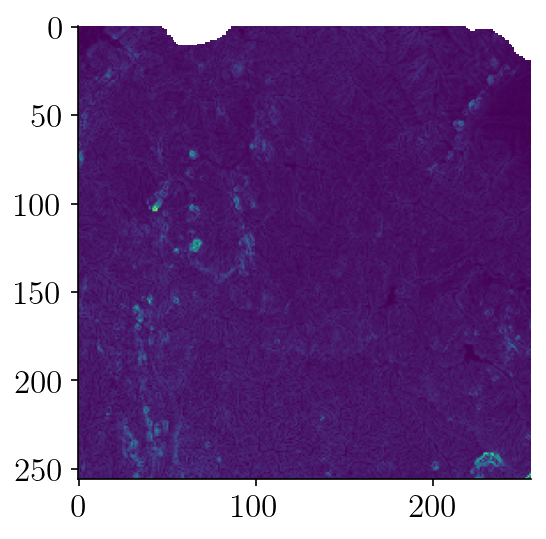

In [51]:
import rasterio
import matplotlib.pyplot as plt
lat, long = h3.h3_to_geo(609534210041970687)
all_ims = None
with rasterio.open('/Users/johnf/Downloads/raw_low_res_dssg/cpiSlopeData.tif', masked=True) as open_file:
    windowed_im = ex_im(open_file,lat,long, 256,256)
    print(np.isnan(windowed_im).sum()/np.prod(windowed_im.shape))
    # plt.imshow(windowed_im[0,:,:])
    # plt.show()
    if all_ims is None: 
        all_ims = windowed_im
    else:
        all_ims = np.vstack((all_ims,windowed_im))
    
    

In [72]:
from stc_unicef_cpi.data.process_geotiff import extract_ims_from_hex_codes as get_ims

In [71]:
all_ims = get_ims(tif_files,nga_df.hex_code.values,256,256)

Overall, 25 bands found in datasets


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1358 [00:00<?, ?it/s]

  0%|          | 0/1358 [00:00<?, ?it/s]

  0%|          | 0/1358 [00:00<?, ?it/s]

  0%|          | 0/1358 [00:00<?, ?it/s]

  0%|          | 0/1358 [00:00<?, ?it/s]

  0%|          | 0/1358 [00:00<?, ?it/s]

  0%|          | 0/1358 [00:00<?, ?it/s]

  0%|          | 0/1358 [00:00<?, ?it/s]

  0%|          | 0/1358 [00:00<?, ?it/s]

WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, tiff not in lat/long
WARNING, t

## Run below to save to disk - warning ~12GB sparse / ~17GB dense

In [79]:
with open("/Users/johnf/Downloads/raw_low_res_dssg/clean/all_bands_centered_v1.npy", 'wb') as f:
    np.save(f, all_ims)

In [80]:
from humanfriendly import format_size
def get_memsize(x):
    print("Memory size of array in bytes:",
        format_size(x.size * x.itemsize))


In [82]:
from scipy.sparse import csr_matrix

In [84]:
all_ims.shape

(1358, 25, 256, 256)

In [86]:
sparse_ims = [[csr_matrix(band) for band in im] for im in all_ims]

In [89]:
print(format_size(np.sum([[band.data.nbytes + band.indptr.nbytes + band.indices.nbytes for band in im] for im in sparse_ims])))

12.08 GB


In [ ]:
import pickle
with "/Users/johnf/Downloads/raw_low_res_dssg/clean/sparse_all_bands_centered_v1.pkl", 'wb') as f:
    pickle.dump(sparse_ims,f)